## Imports

In [3]:
import typing
import io
import os

import torch
import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.backends.backend_pdf import PdfPages

from urllib.request import urlretrieve
import torch.nn.functional as nnf
from PIL import Image
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

In [4]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## Attention Visualization Utilities

In [22]:
def attentionVisualizer(fileName, text_prompts):
    # Load and process the image
    image_path = fileName
    image_file = fileName.split('/')[-1]
    image_name = image_file.split('.')
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))

    # Process image and text
    inputs = processor(text=text_prompts, images=image, return_tensors="pt", padding=True)
    image_tensor = inputs['pixel_values']
    image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
    inputs['pixel_values'] = image_tensor
    inputs.pixel_values.requires_grad_(True)

    # Get the model outputs for original image
    outputs_orig = model(**inputs, output_attentions=True)
    # attentions
    attn_mat = torch.stack(outputs_orig.vision_model_output.attentions)
    attentions = outputs_orig.vision_model_output.attentions
    logits_per_image = outputs_orig.logits_per_image  # this is the image-text similarity score
    original_probs = nnf.softmax(logits_per_image, dim=1)
    top_p, top_class = original_probs.topk(1, dim = 1)

    att_mat = torch.stack(attentions).squeeze(1)
    att_mat = torch.mean(att_mat, dim=1)
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    # Extracting the attention matrices
    att_mat = torch.stack(attentions).squeeze(1)
    # Reducing dimensionality for simplicity
    att_mat = torch.mean(att_mat, dim=1)
    # Normalizing the attention matrices to make them easier to visualize
    aug_att_mat = att_mat + torch.eye(att_mat.size(1))
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Initialize joint attention with the first layer's attention
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # The final layer's joint attention will be used for visualization
    v = joint_attentions[-1]

    # Assuming joint_attentions, aug_att_mat, image, and image_file are defined elsewhere
    # v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask, (224, 224))

    mask = (mask - mask.min()) / (mask.max()-mask.min())
    
    colored_mask = cm.viridis_r(mask)[:, :, :3]
    colored_mask_image = (colored_mask * 255).astype(np.uint8)
    original_image_np = np.array(image)
    blended_image = cv2.addWeighted(original_image_np, 0.5, colored_mask_image, 1, 0)
    blended_image_pil = Image.fromarray(blended_image)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    ax1.set_title(f'Image name : {image_name[0]}')
    ax2.set_title('Attention Map')
    ax1.imshow(image)
    im = ax2.imshow(blended_image_pil)

    sm = ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    fig.colorbar(sm, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)

    image_name_wo_ext = os.path.splitext(image_file)[0]
    fig.text(0.5, 0.02, f'top_p : {top_p}, top_class : {top_class}', ha='center', va='bottom')

    plt.show()

## Visualizing on raw data

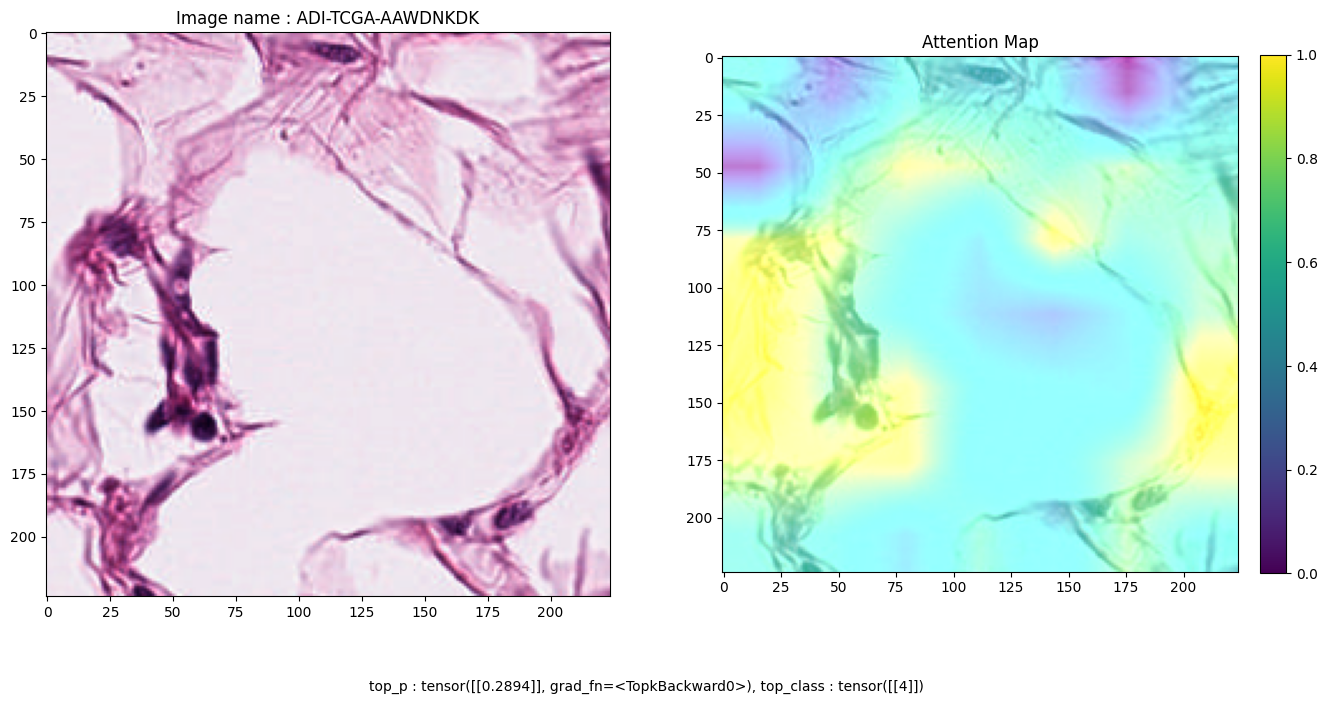

In [23]:
text_prompts = ["an H&E image of adipose",
                    "an H&E image of background",
                    "an H&E image of debris",
                    "an H&E image of lymphocytes",
                    "an H&E image of mucus",
                    "an H&E image of smooth muscle",
                    "an H&E image of normal colon mucosa",
                    "an H&E image of cancer-associated stroma",
                    "an H&E image of colorectal adenocarcinoma epithelium",
                   ""
                   ]
attentionVisualizer("./sample_Data/original_images/ADI-TCGA-AAWDNKDK.tif", text_prompts)

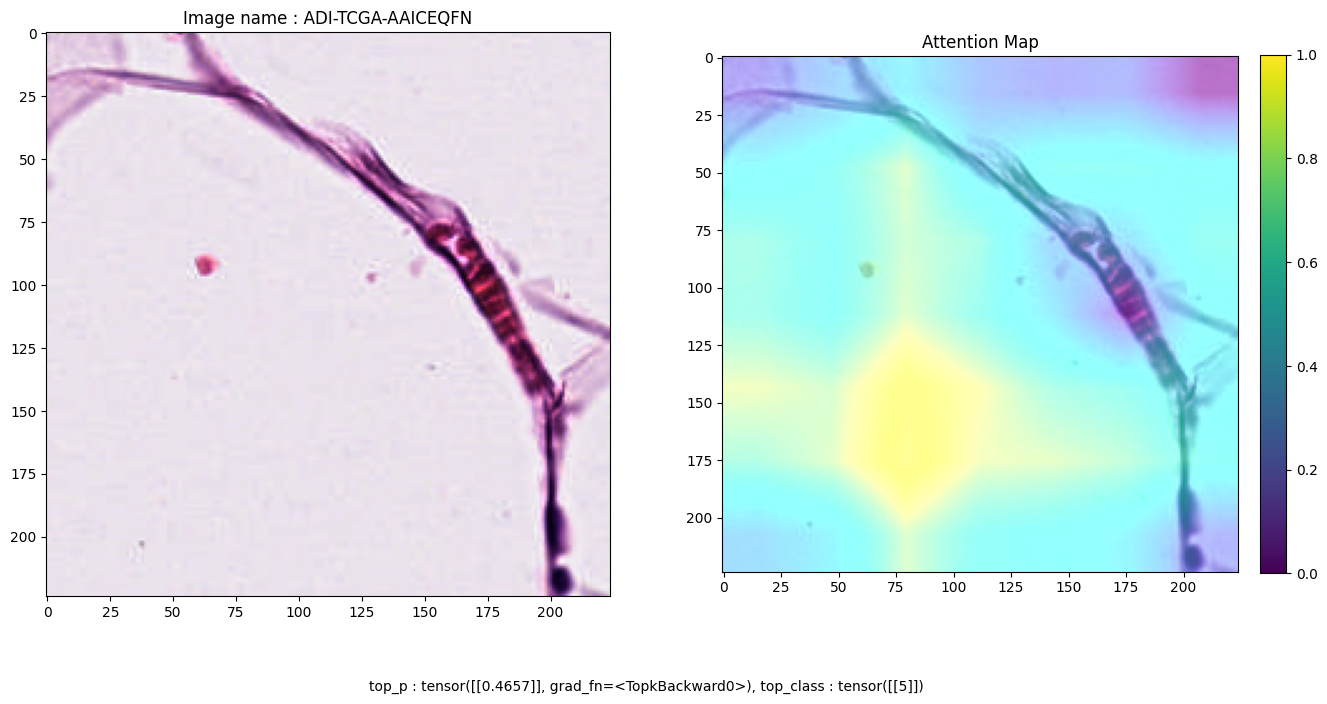

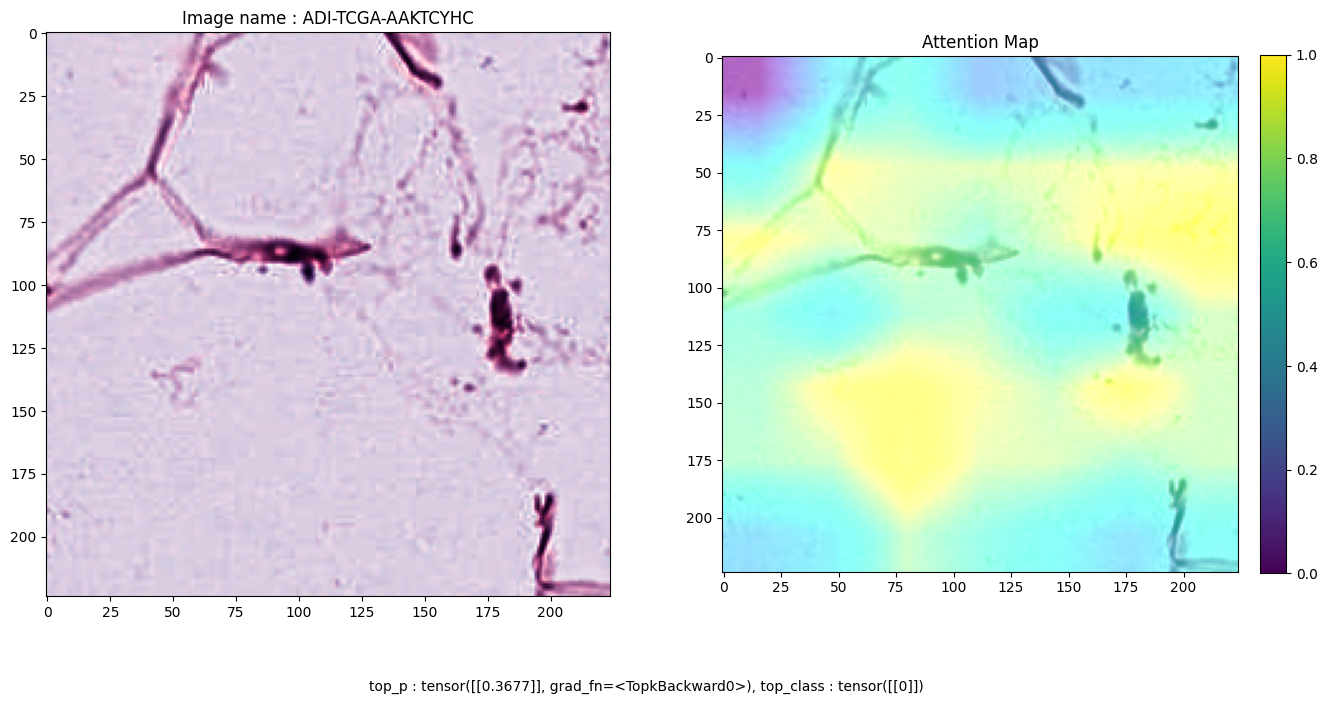

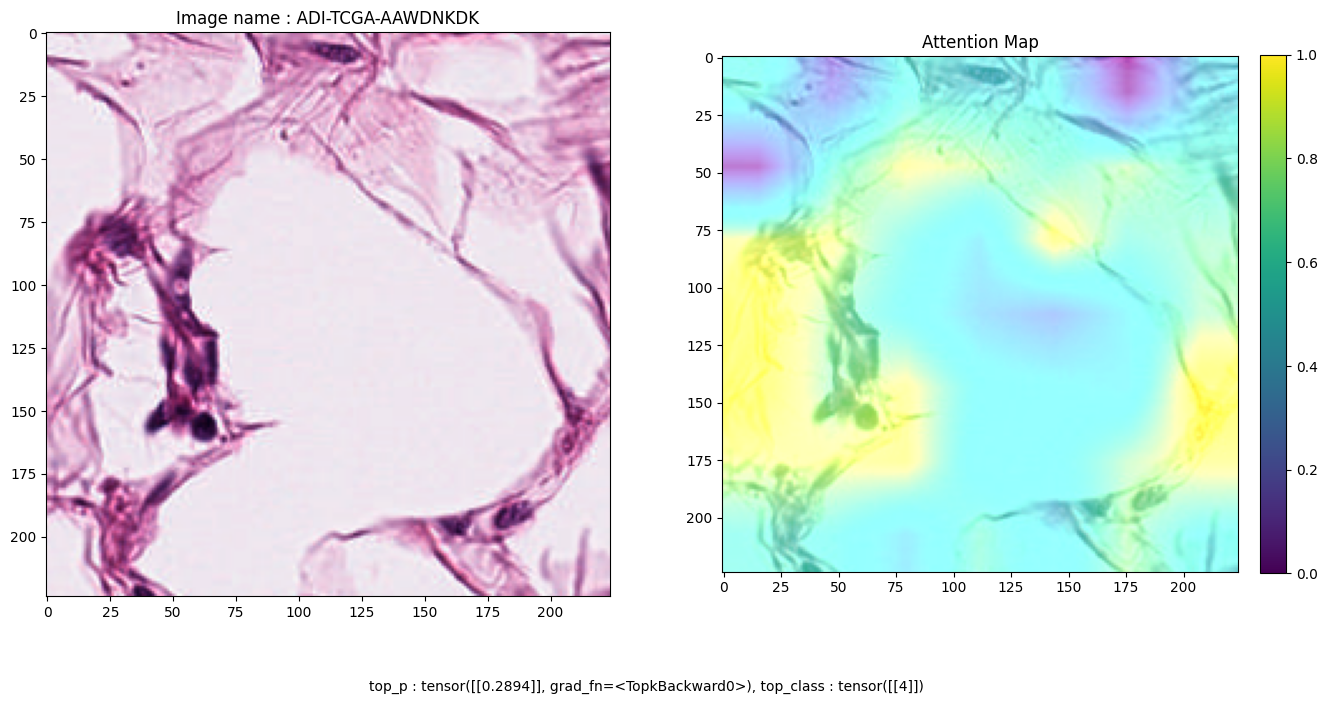

In [26]:
directory_path = './sample_Data/original_images'

image_files = os.listdir(directory_path)
image_files = sorted(image_files)
original_images = []
for i, image_file in enumerate(image_files):
    if(image_file.endswith('.tif') or image_file.endswith('.tiff')):
        img_path = os.path.join(directory_path, image_file)
        attentionVisualizer(img_path, text_prompts)